In [1]:
%load_ext autoreload
%autoreload 2
import os
from os.path import isfile, split
import sys
import pandas as pd
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    print('Added {} to path.'.format(nb_dir))

Added /Users/naitsaadathiziri/Documents/MVA/Time_Series/Project to path.


Populating the interactive namespace from numpy and matplotlib


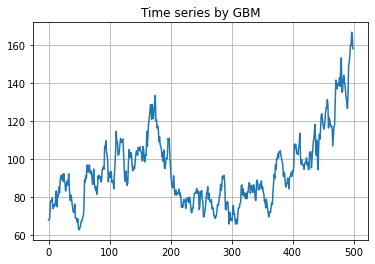

In [16]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import cwt ## change import wt into import cwt, then, in cwt, change from .mytracing import skeletor into from mytracing import skeletor
plt.rcParams['axes.grid'] = True

def gbm(T):
    """
    Geometric Brownian Motion.
    """
    ts = range(0, T)
    np.random.seed(None)
    rands = np.random.randn(T) 
    Ws = [np.sum(rands[:t]) / np.sqrt(T) for t in ts]
    sig = np.exp(Ws)
    ys = sig * (np.random.choice(100) + 1)
    plt.plot(ys)
    plt.title('Time series by GBM')
    return ys

    
ts = gbm(T=500)
scales = np.arange(1, len(ts)/2)

In [17]:
def trim_wavelet(x, psi, tol=1e-2):
    l = np.argmax(np.abs(psi)>tol)
    r = len(x) - np.argmax(np.abs(psi[::-1])>tol) - 1
    x = x[l:r]
    psi = psi[l:r]
    x = x / x[-1]
    return x, psi

Text(0.5, 1.0, 'Gaussian 2nd derivative (LoG)')

<Figure size 1152x1152 with 0 Axes>

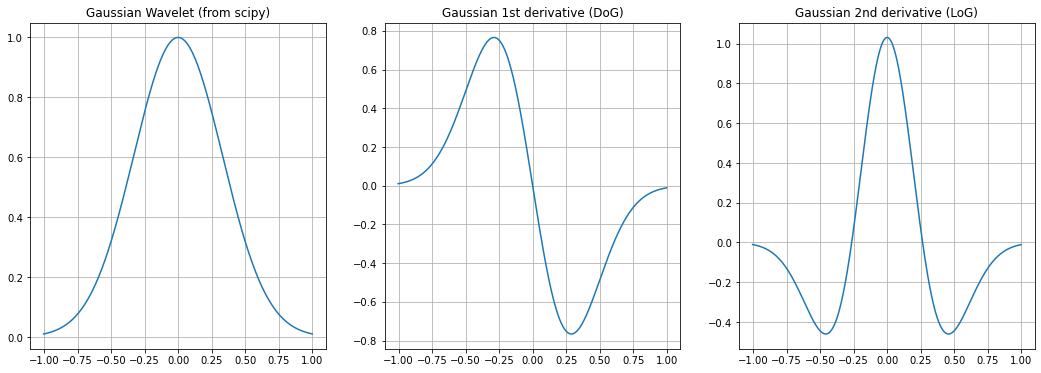

In [18]:
gaus1 = pywt.ContinuousWavelet('gaus1')
gaus2 = pywt.ContinuousWavelet('gaus2')

phi_1, x_1 = gaus1.wavefun(level=10)
phi_2, x_2 = gaus2.wavefun(level=10)
M = len(x_1)
phi_0 = signal.gaussian(M, M/10)
plt.figure(figsize=(16,16))
f, axarr = plt.subplots(1, 3, sharey=False, figsize=(18,6))
x_0, phi_0 = trim_wavelet(x_1, phi_0)
x_1, phi_1 = trim_wavelet(x_1, phi_1)
x_2, phi_2 = trim_wavelet(x_2, phi_2)
axarr[0].plot(x_0, phi_0)
axarr[0].set_title('Gaussian Wavelet (from scipy)')
axarr[1].plot(x_1, phi_1)
axarr[1].set_title('Gaussian 1st derivative (DoG)')
axarr[2].plot(x_2, phi_2)
axarr[2].set_title('Gaussian 2nd derivative (LoG)')

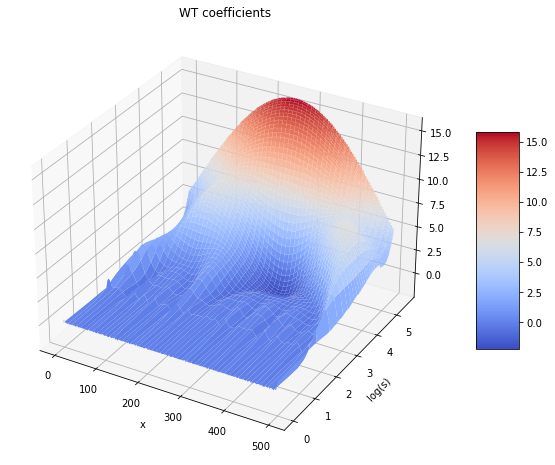

In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm

sig = ts

# normalize the signal to fit in the wavelet
sig = cwt.normalize_signal(sig)

# Run the transform
w_coefs, freqs = pywt.cwt(sig, scales, 'mexh')

X = np.arange(np.shape(sig)[0])
Y = np.log(scales)
Z = w_coefs
x, y = np.meshgrid(X,Y)

# show hight map in 3d
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, Z, cmap=cm.coolwarm)
plt.title('WT coefficients')
plt.xlabel("x")
plt.ylabel("log(s)")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

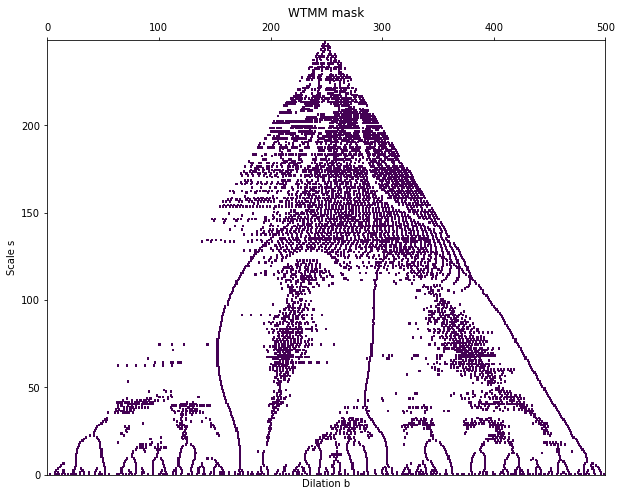

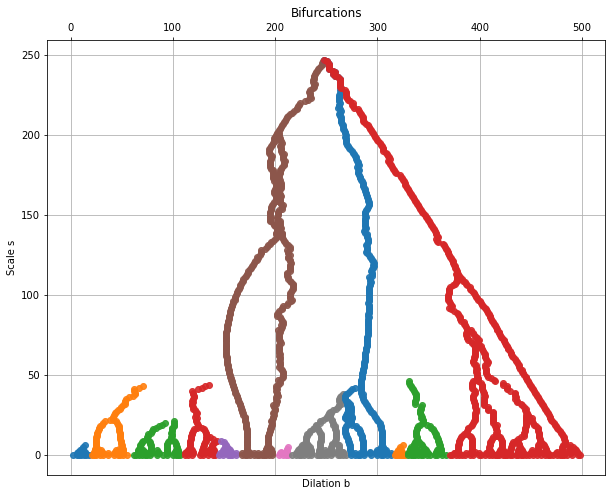

In [29]:
wtmm_trend, coefs_trend, ridges_trend = cwt.wtmm(ts, wavelet=gaus1, plot=True, remove_inf=True,
                                             order=1, proximity=10, scales=scales) ## change wt.cwt.wtmm into cwt.wtmm

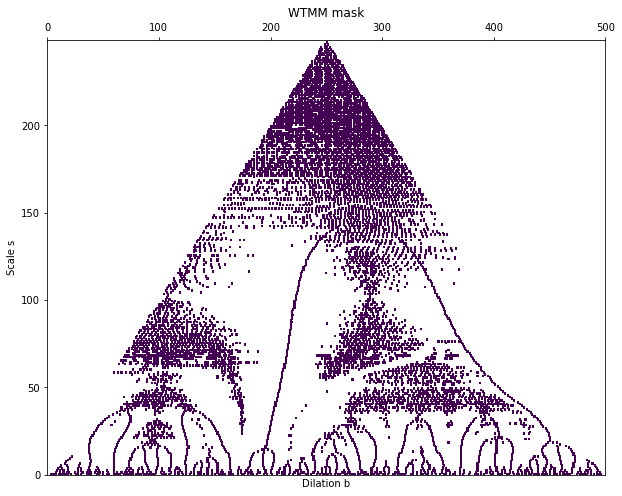

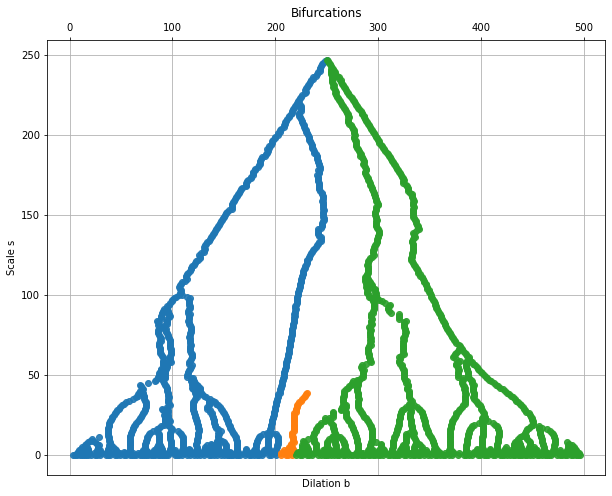

In [26]:
wtmm_curv, coefs_curv, ridges_curv = cwt.wtmm(ts, wavelet=gaus2, plot=True, remove_inf=True,
                                          order=1, proximity=15, scales=scales) ## idem

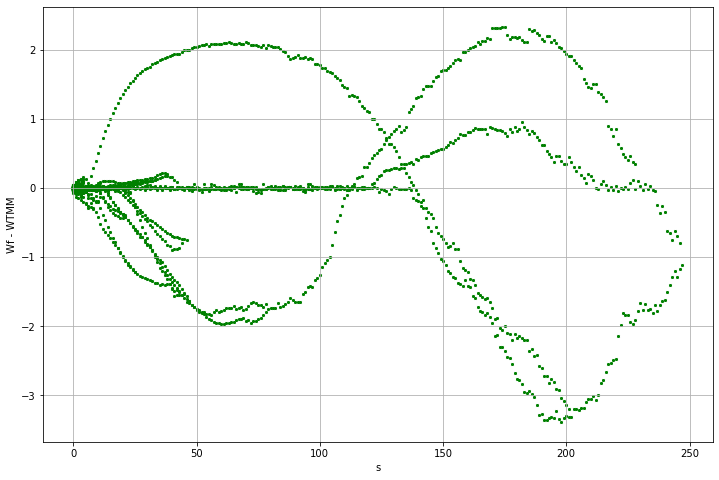

In [89]:
## TODO : use log for the scale axis

plt.figure(figsize=(12,8))
m = np.shape(wtmm_trend)[1]
for j in range(m):
    #print("column ", j)
    cond = wtmm_trend[:,j]!=0 ## let us start the scales at 1
    scales_idx = np.where(cond)[0] ## + 1 because we started the scales at 1
    #print(np.sum(1.*wtmm_trend[:,j]!=0))
    if len(scales_idx)!=0 : 
        #print("idx ", scales_idx)
        list_j = wtmm_trend[scales_idx,j]
    
        #print("list_coef ",list_j)
        plt.scatter((scales_idx), list_j, marker="x", s=5, c='green')

plt.ylabel("Wf - WTMM")
plt.xlabel("s")
plt.show()

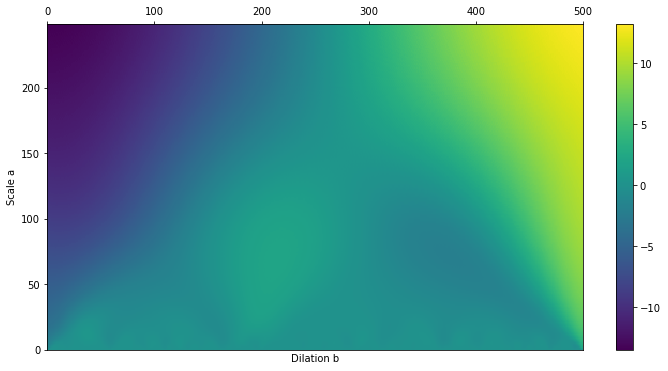

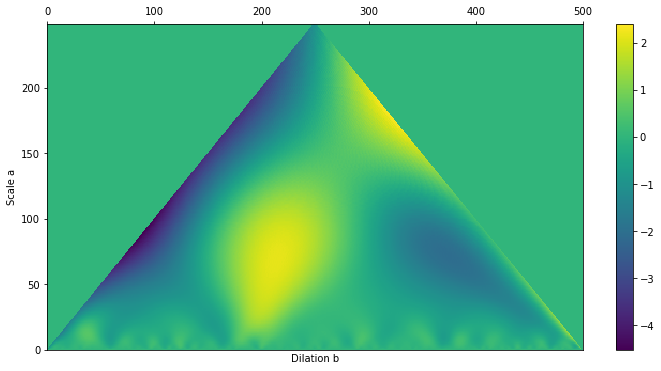

In [28]:
#to_plot = np.ma.masked_array(wtmm_curv, mask=wtmm_curv==0)
to_plot = coefs_trend
plt.figure(figsize=(12, 6))
plt.pcolormesh(to_plot)
plt.xlabel('Dilation b')
plt.ylabel('Scale a')
plt.colorbar()
ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()

cleared = cwt.clear_edges(coefs_trend.copy(), scales=range(coefs_trend.shape[0]), wavelet=gaus1) ##remove wt.
plt.figure(figsize=(12, 6))
plt.pcolormesh(cleared)
plt.xlabel('Dilation b')
plt.ylabel('Scale a')
plt.colorbar()
ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()

In [9]:
for ridge in ridges_trend:
    print('points: ', len(ridge.get_points()))
    print('spread: ', ridge.get_spread())
    print('WT coeff: ', coefs_trend[ridge.points[0]])
    #print('get_n_branches_at_half_and_qrt(): ', ridge.get_n_branches_at_half_and_qrt(verbose=True))
    print(ridge.get_b(a=80))
    break
    

points:  282
spread:  (40, 28)
WT coeff:  -4.881860103061096
88


In [ ]:
def local_effective_holder(WTMM_coefs, s_lo, s_hi):
    
    